## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs are emerging techniques that model high dimensional distribution of data. They achieve this by training a pair of networks, Generator and Discriminator, in competition with each other. As an analogy we can think of these models as an art forger and the other being an art expert. In GAN literature we term Generator as the forger and the duty of the generator is to produce fake images(forgeries) to deceive the art expert(Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them and find the fake images. Both are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their models continuously. The models are trained until the generator produces the fake images that are indistinguishable with the real images.  <br>

In this setup, the generator do not have access to the synthetic images whereas the discriminator has access to both the real and fake images. While training the models, the supervisory signal to the discriminator is given by knowing whether the images came from a real image stack or generated image stack whereas the generator in the setup receives the error signal only from the discriminator.  

Let us define Discriminator D that takes image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practise, G and D are trained alternately i.e., For a fixed generator G, the discriminator D is trained to classify the training data as real(output a value close to 1) or fake(output a value close to 0). In the next step we freeze the Discriminator assuming it as optimal and we the train the generator G to produce a image(fake) that outputs a value close to 1(real) when passed through the discriminator D. Thus, if the generator is perfectly trained then the discriminator D will be maximally confused by the images generated by G and predicts 0.5 for all the inputs. 



In this assignment, we will try to implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that goes into the generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves


Let us implement each of the part and train the overall model:

In [278]:
## import packages

import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



## Checks for the availability of GPU 
if torch.cuda.is_available():
    print("working on gpu!")
    device = 'cuda'
else:
    print("No gpu! only cpu ;)")
    device = 'cpu'
    

working on gpu!


In [279]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

In [280]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

train_bs = 128

transform = transforms.Compose([transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
        ])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)


In GANs we input random noise through the generator to produce fake images which resemble the real distribution. Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions.

In [281]:

def noise(bs, dim):
    out = (torch.randn((bs, dim))/5).to(device)
#     out = (torch.FloatTensor(bs, dim).uniform_(-1.0, 1.0)).to(device)
    return out

Generator architecture:

- noise_dim -> 1024
- ReLU
- 1024 -> 1024
- ReLU
- 1024 -> 784
- TanH 
- clip image [-1, +1]

In [282]:

class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Linear(noise_dim, 1024)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
#         self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(1024, 1024)
        self.tanh = nn.Tanh()
        self.layer4 = nn.Linear(1024, out_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.leaky_relu(x)
#         x = self.layer2(x)
#         x = self.leaky_relu(x)
        x = self.layer3(x)
        x = self.leaky_relu(x)
        x = self.layer4(x)
        x = self.tanh(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x
        
        
        
        

Discriminator architecture:

- input_size->256
- LeakyReLU alpha=0.01
- 256e->256
- LeakyReLU alpha-=0.01
- 256->1

In [283]:
## Similar to the generator, we now define a discriminator which takes in a vector and output a value between 
## 0 and 1. We define the Discriminator as given in the above architecture.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Linear(784, 256)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        self.layer2 = nn.Linear(256, 1)
        
#         self.layer3 = nn.Linear(256, 1)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
#         x = self.leaky_relu(x)
#         x = self.layer3(x)
        return x
        
        

In [284]:
bce_loss = nn.BCEWithLogitsLoss()

In [285]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    d1 = bce_loss(logits_real, targets_real)
    d2 = bce_loss(logits_fake, targets_fake)
    total_loss = d1 + d2
    return total_loss
    

In [286]:
def GLoss(logits_fake, targets_real):
    g_loss = bce_loss(logits_fake, targets_real)
    return g_loss

In [287]:
noise_dim = 96
epochs = 100

generator = Generator(noise_dim)
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

In [288]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
























  0%|          | 0/100 [00:00<?, ?it/s]

D Loss:  0.9246622323989868
G Loss:  0.917823076248169


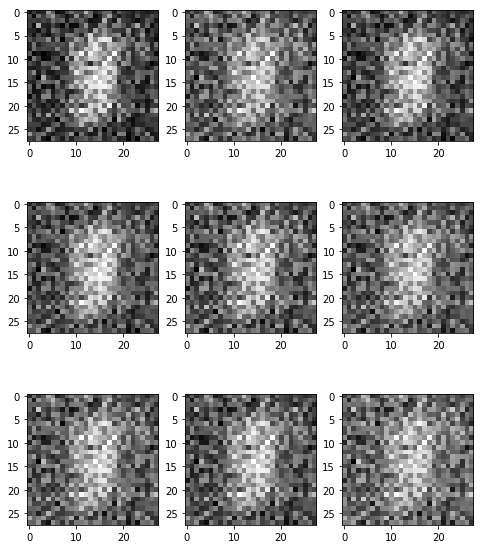
























  1%|          | 1/100 [00:13<21:29, 13.03s/it]






















  2%|▏         | 2/100 [00:25<21:06, 12.92s/it]

D Loss:  0.736965537071228
G Loss:  1.6774276494979858
D Loss:  0.6838933825492859
G Loss:  1.6571117639541626


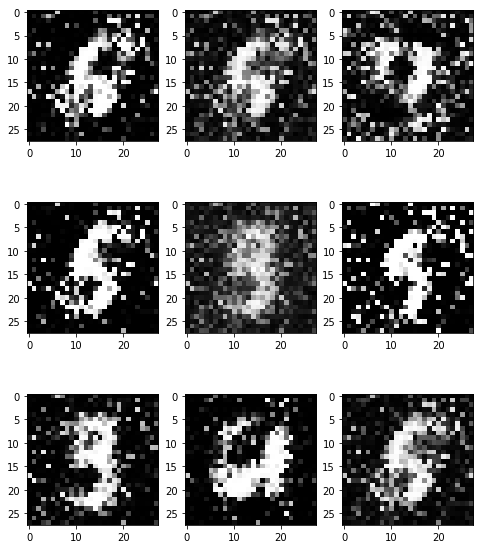
























  3%|▎         | 3/100 [00:39<21:09, 13.09s/it]






















  4%|▍         | 4/100 [00:52<20:48, 13.01s/it]

D Loss:  0.7429674863815308
G Loss:  2.24570369720459
D Loss:  0.6577296257019043
G Loss:  1.8689327239990234


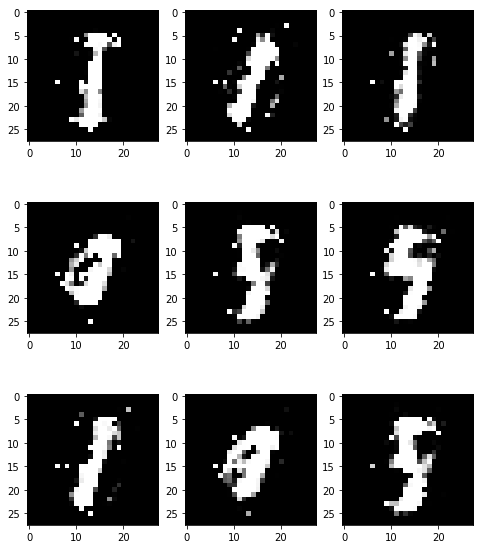
























  5%|▌         | 5/100 [01:05<20:53, 13.20s/it]






















  6%|▌         | 6/100 [01:18<20:25, 13.04s/it]

D Loss:  0.6645286083221436
G Loss:  1.975387692451477
D Loss:  0.6792876124382019
G Loss:  1.7265396118164062


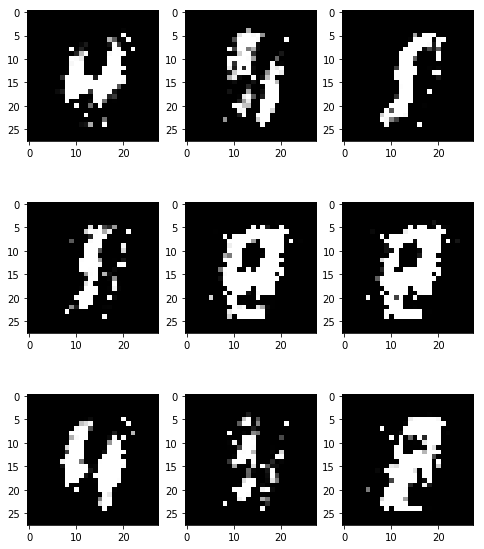
























  7%|▋         | 7/100 [01:31<20:18, 13.10s/it]






















  8%|▊         | 8/100 [01:44<19:57, 13.02s/it]

D Loss:  0.6696169376373291
G Loss:  2.07029390335083
D Loss:  0.6959531903266907
G Loss:  1.7277204990386963


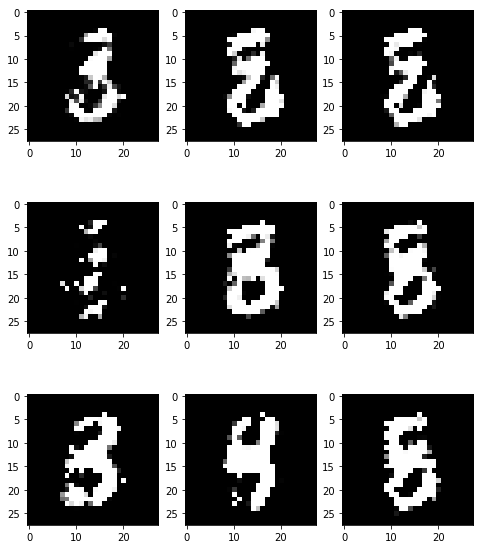
























  9%|▉         | 9/100 [01:58<20:23, 13.45s/it]






















 10%|█         | 10/100 [02:11<20:00, 13.33s/it]

D Loss:  0.6535849571228027
G Loss:  1.898629069328308
D Loss:  0.6537055969238281
G Loss:  1.9032236337661743


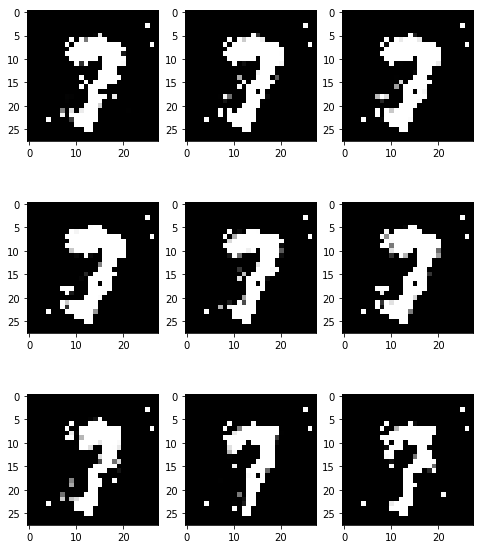
























 11%|█         | 11/100 [02:25<20:05, 13.54s/it]






















 12%|█▏        | 12/100 [02:38<19:27, 13.27s/it]

D Loss:  0.6623150110244751
G Loss:  1.9892654418945312
D Loss:  0.666126012802124
G Loss:  1.6695743799209595


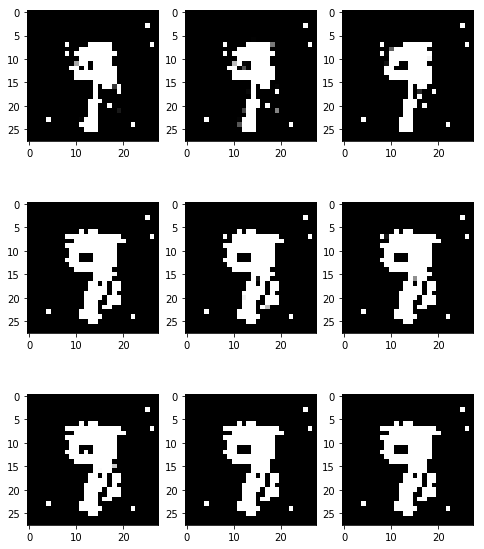
























 13%|█▎        | 13/100 [02:52<19:21, 13.35s/it]






















 14%|█▍        | 14/100 [03:04<18:52, 13.17s/it]

D Loss:  0.6580593585968018
G Loss:  2.050309419631958
D Loss:  0.6663799285888672
G Loss:  2.068871259689331


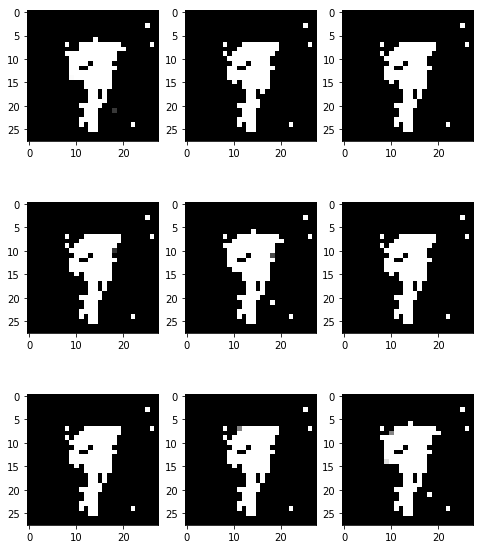
























 15%|█▌        | 15/100 [03:18<18:48, 13.28s/it]






















 16%|█▌        | 16/100 [03:31<18:21, 13.11s/it]

D Loss:  0.663723349571228
G Loss:  1.9336512088775635
D Loss:  0.6697415113449097
G Loss:  2.055919885635376


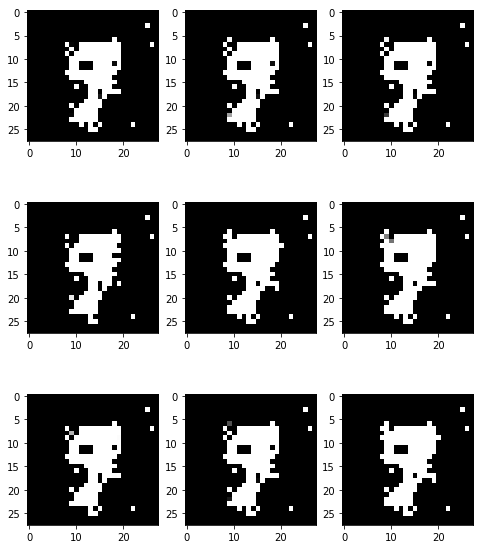
























 17%|█▋        | 17/100 [03:44<18:19, 13.25s/it]






















 18%|█▊        | 18/100 [03:57<17:54, 13.10s/it]

D Loss:  0.642197847366333
G Loss:  2.209559917449951
D Loss:  0.6549630165100098
G Loss:  1.9135143756866455


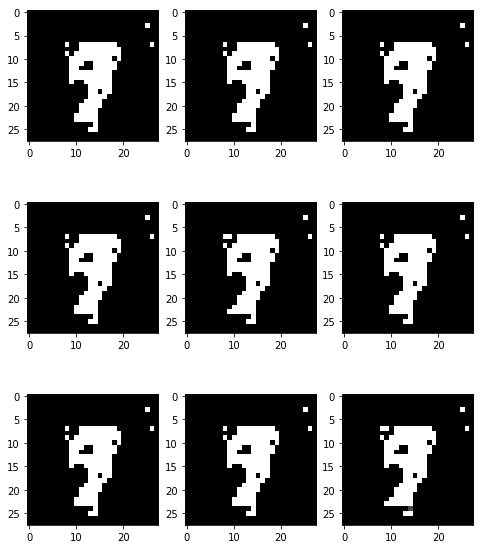
























 19%|█▉        | 19/100 [04:09<17:24, 12.89s/it]






















 20%|██        | 20/100 [04:21<16:41, 12.52s/it]

D Loss:  0.6702008247375488
G Loss:  1.9853473901748657
D Loss:  0.6649125814437866
G Loss:  1.902014136314392


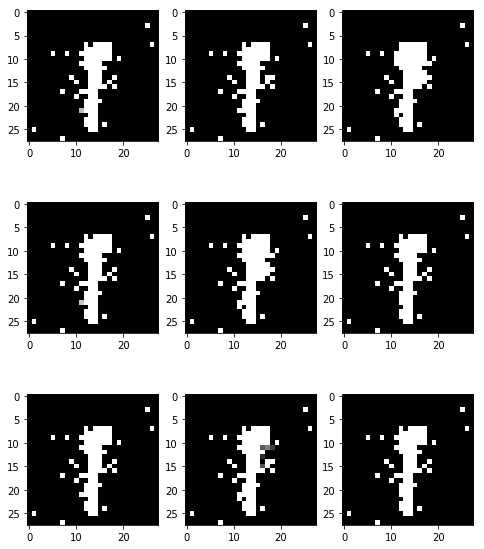
























 21%|██        | 21/100 [04:33<16:25, 12.47s/it]






















 22%|██▏       | 22/100 [04:45<15:52, 12.21s/it]

D Loss:  0.6495668888092041
G Loss:  2.0646398067474365
D Loss:  0.6128420829772949
G Loss:  2.3329739570617676


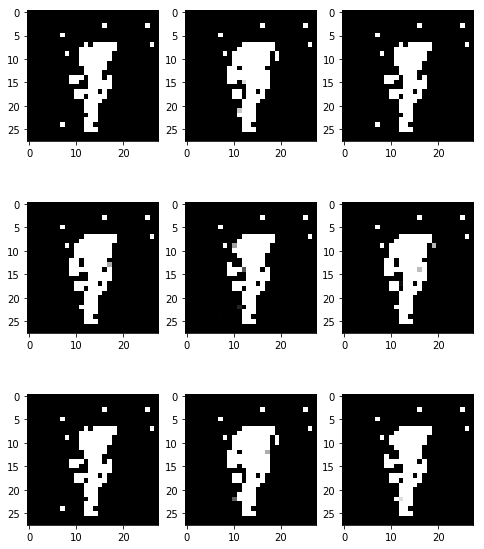
























 23%|██▎       | 23/100 [04:57<15:44, 12.27s/it]






















 24%|██▍       | 24/100 [05:09<15:16, 12.06s/it]

D Loss:  0.7179070115089417
G Loss:  2.179734230041504
D Loss:  0.6432612538337708
G Loss:  2.1318306922912598


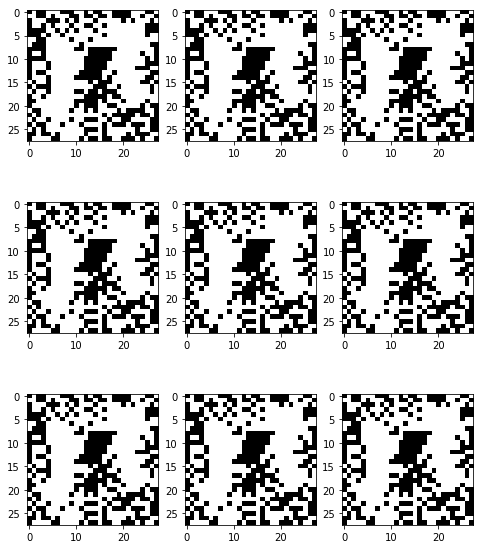
























 25%|██▌       | 25/100 [05:21<15:10, 12.14s/it]






















 26%|██▌       | 26/100 [05:33<14:47, 11.99s/it]

D Loss:  0.6346914172172546
G Loss:  2.0465431213378906
D Loss:  0.6485958099365234
G Loss:  2.0371952056884766


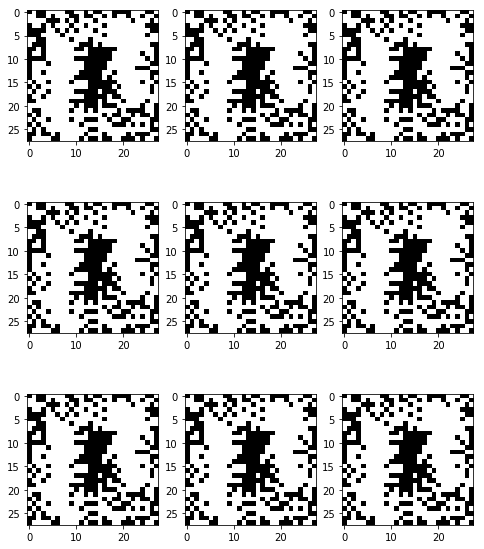
























 27%|██▋       | 27/100 [05:45<14:43, 12.11s/it]






















 28%|██▊       | 28/100 [05:57<14:21, 11.96s/it]

D Loss:  0.6486874222755432
G Loss:  2.173760414123535
D Loss:  0.6373879909515381
G Loss:  2.160336971282959


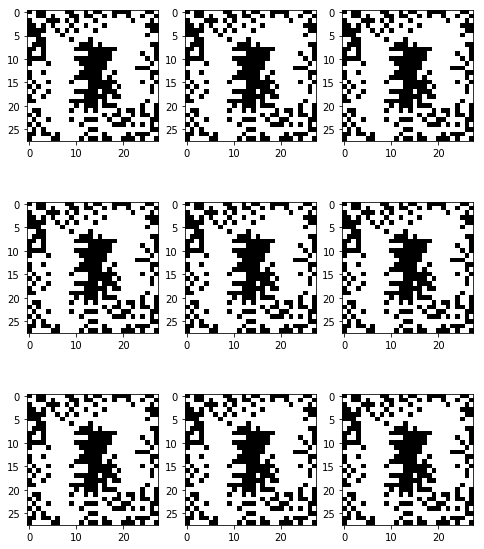
























 29%|██▉       | 29/100 [06:09<14:17, 12.08s/it]






















 30%|███       | 30/100 [06:21<13:55, 11.94s/it]

D Loss:  0.670555830001831
G Loss:  1.9651743173599243
D Loss:  0.6460863351821899
G Loss:  2.185418128967285


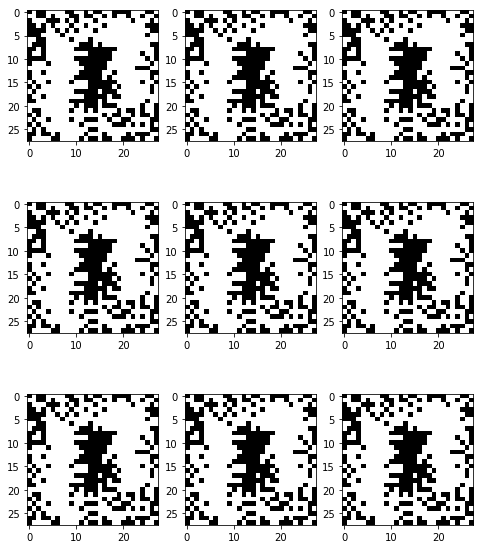
























 31%|███       | 31/100 [06:33<13:54, 12.10s/it]






















 32%|███▏      | 32/100 [06:45<13:34, 11.98s/it]

D Loss:  0.654483437538147
G Loss:  2.0846266746520996
D Loss:  0.6244142055511475
G Loss:  2.221769094467163


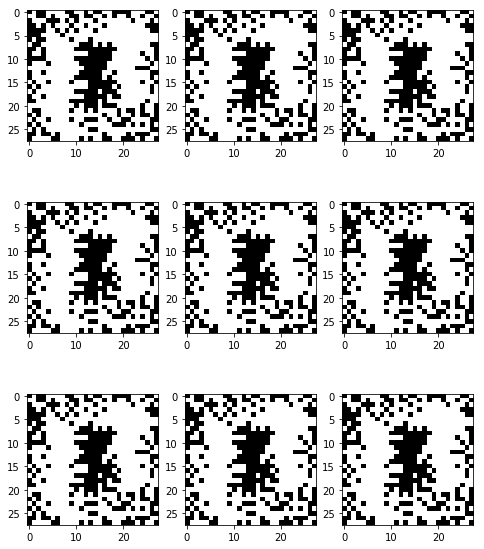
























 33%|███▎      | 33/100 [06:57<13:32, 12.12s/it]






















 34%|███▍      | 34/100 [07:09<13:10, 11.98s/it]

D Loss:  0.665255606174469
G Loss:  2.028795003890991
D Loss:  0.6793704032897949
G Loss:  1.935247540473938


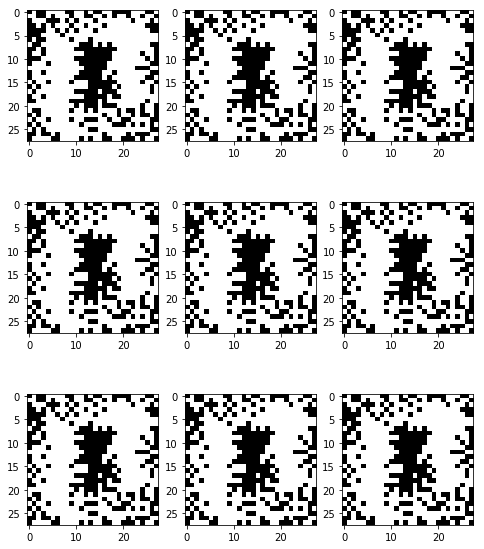
























 35%|███▌      | 35/100 [07:22<13:07, 12.12s/it]






















 36%|███▌      | 36/100 [07:33<12:48, 12.01s/it]

D Loss:  0.6584001779556274
G Loss:  2.114025354385376
D Loss:  0.6508024334907532
G Loss:  1.9764598608016968


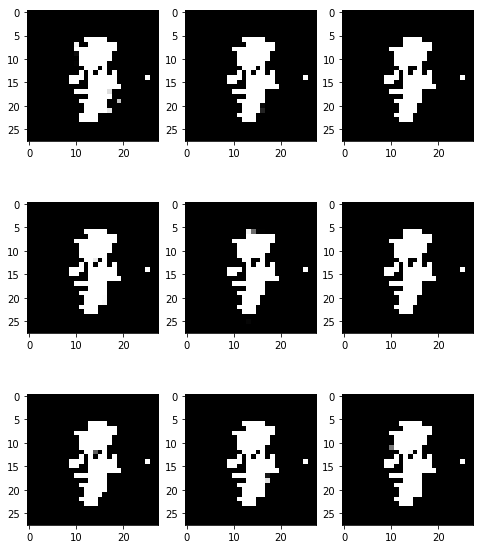
























 37%|███▋      | 37/100 [07:47<13:02, 12.42s/it]






















 38%|███▊      | 38/100 [07:59<12:52, 12.45s/it]

D Loss:  0.6673790216445923
G Loss:  2.000410795211792
D Loss:  0.6805756688117981
G Loss:  2.1798744201660156


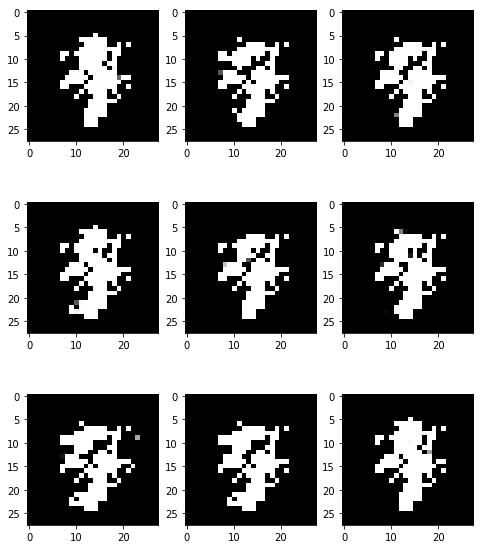
























 39%|███▉      | 39/100 [08:13<12:59, 12.77s/it]






















 40%|████      | 40/100 [08:26<12:46, 12.77s/it]

D Loss:  0.6439676284790039
G Loss:  2.0679407119750977
D Loss:  0.6781671047210693
G Loss:  2.093306064605713


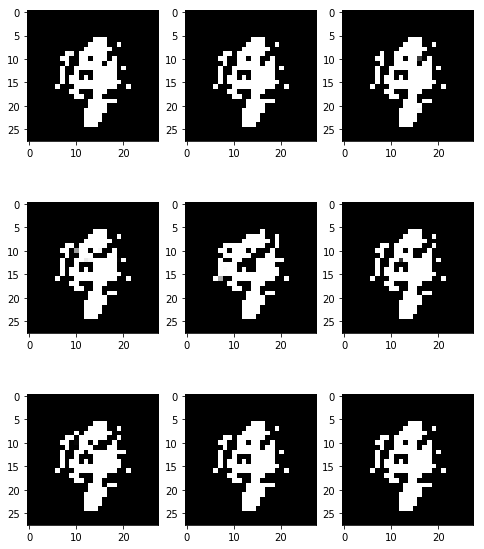
























 41%|████      | 41/100 [08:39<12:44, 12.96s/it]






















 42%|████▏     | 42/100 [08:52<12:28, 12.90s/it]

D Loss:  0.6573625206947327
G Loss:  2.0436320304870605
D Loss:  0.661149263381958
G Loss:  2.0721936225891113


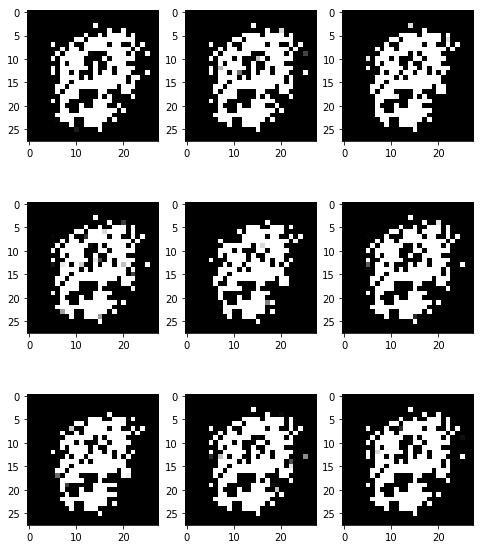
























 43%|████▎     | 43/100 [09:05<12:22, 13.02s/it]






















 44%|████▍     | 44/100 [09:18<12:04, 12.93s/it]

D Loss:  0.6683787107467651
G Loss:  2.1067404747009277
D Loss:  0.6617182493209839
G Loss:  2.054621934890747


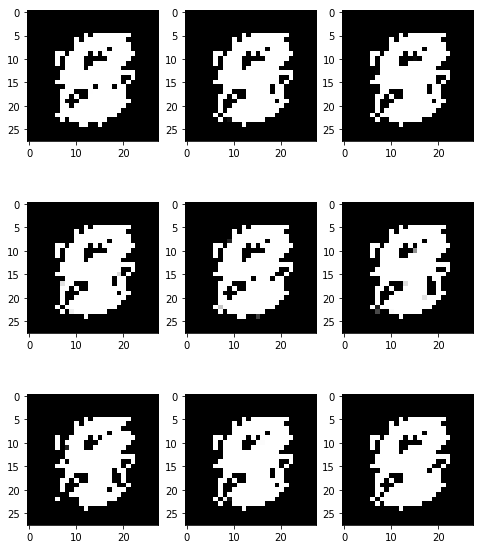
























 45%|████▌     | 45/100 [09:30<11:44, 12.80s/it]






















 46%|████▌     | 46/100 [09:42<11:11, 12.44s/it]

D Loss:  0.6218723654747009
G Loss:  2.202057361602783
D Loss:  0.6728551983833313
G Loss:  1.9295477867126465


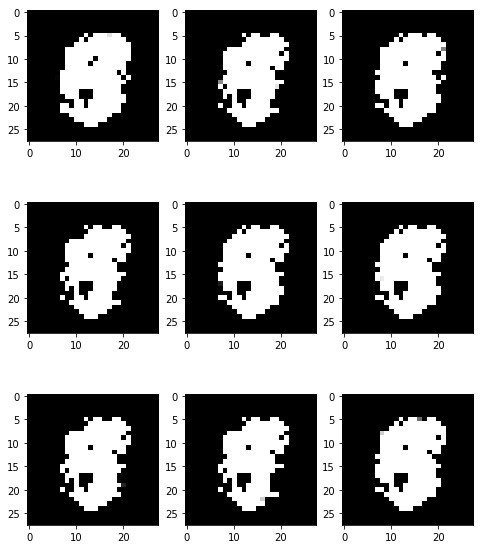
























 47%|████▋     | 47/100 [09:54<10:57, 12.41s/it]






















 48%|████▊     | 48/100 [10:06<10:34, 12.19s/it]

D Loss:  0.6648284792900085
G Loss:  2.0885109901428223
D Loss:  0.6740235090255737
G Loss:  1.939936637878418


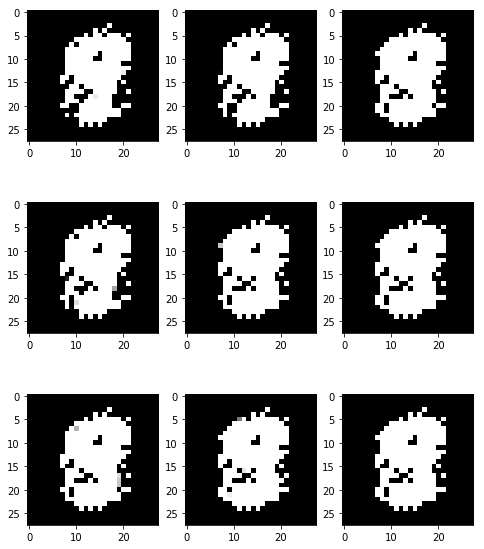
























 49%|████▉     | 49/100 [10:18<10:25, 12.25s/it]






















 50%|█████     | 50/100 [10:30<10:11, 12.22s/it]

D Loss:  0.666530966758728
G Loss:  2.0979247093200684
D Loss:  0.6663156747817993
G Loss:  2.0304150581359863


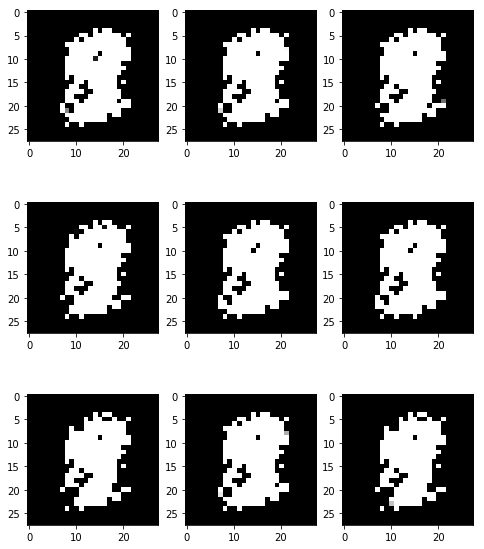
























 51%|█████     | 51/100 [10:44<10:18, 12.62s/it]






















 52%|█████▏    | 52/100 [10:57<10:06, 12.64s/it]

D Loss:  0.6706507205963135
G Loss:  2.1395773887634277
D Loss:  0.6466829776763916
G Loss:  2.0385985374450684


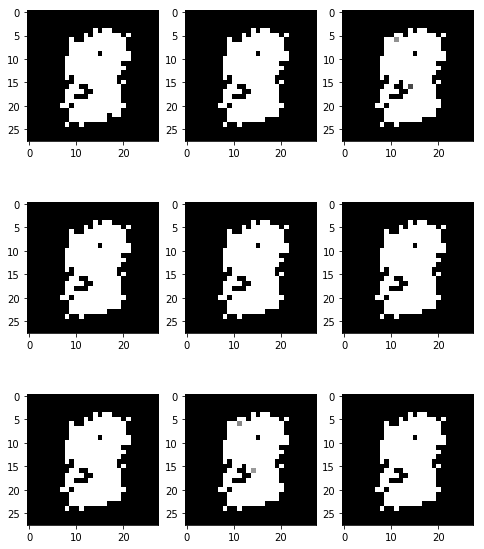
























 53%|█████▎    | 53/100 [11:10<10:02, 12.83s/it]






















 54%|█████▍    | 54/100 [11:22<09:33, 12.47s/it]

D Loss:  0.6527605652809143
G Loss:  2.043390989303589
D Loss:  0.6464711427688599
G Loss:  2.0936105251312256


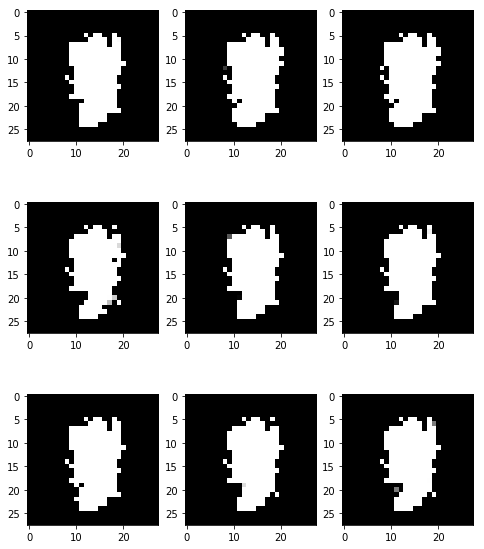
























 55%|█████▌    | 55/100 [11:35<09:31, 12.70s/it]






















 56%|█████▌    | 56/100 [11:48<09:19, 12.72s/it]

D Loss:  0.6650194525718689
G Loss:  2.0732297897338867
D Loss:  0.6498862504959106
G Loss:  2.0577380657196045


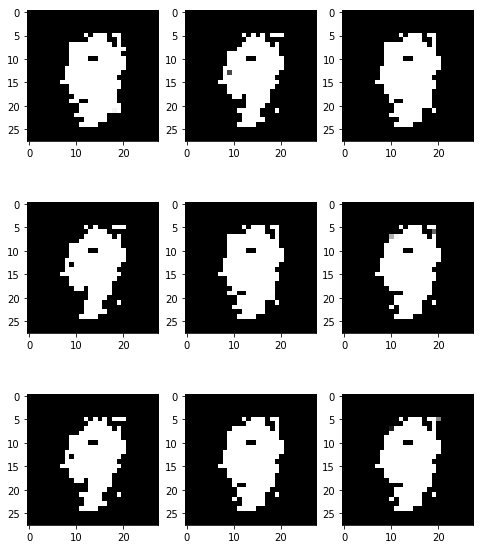
























 57%|█████▋    | 57/100 [12:01<09:15, 12.92s/it]






















 58%|█████▊    | 58/100 [12:14<09:01, 12.88s/it]

D Loss:  0.6420878171920776
G Loss:  2.0777111053466797
D Loss:  0.652621865272522
G Loss:  2.026872396469116


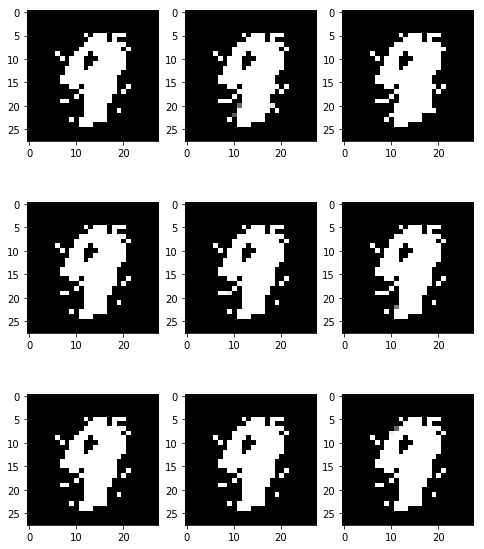
























 59%|█████▉    | 59/100 [12:27<08:55, 13.07s/it]






















 60%|██████    | 60/100 [12:40<08:38, 12.96s/it]

D Loss:  0.651262640953064
G Loss:  2.1305298805236816
D Loss:  0.6737732291221619
G Loss:  1.96647047996521


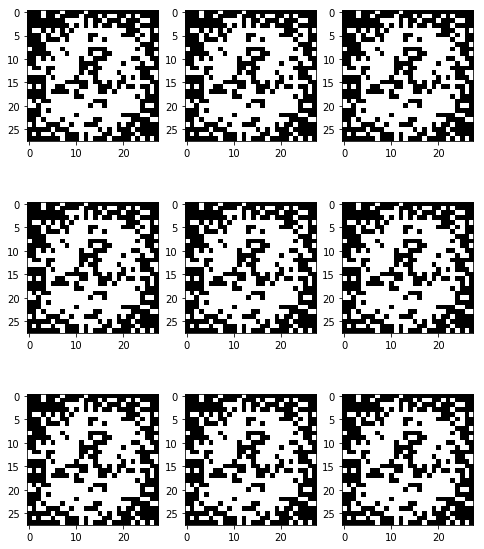
























 61%|██████    | 61/100 [12:53<08:32, 13.14s/it]






















 62%|██████▏   | 62/100 [13:06<08:14, 13.02s/it]

D Loss:  0.6509164571762085
G Loss:  2.118401050567627
D Loss:  0.6578080058097839
G Loss:  2.079249382019043


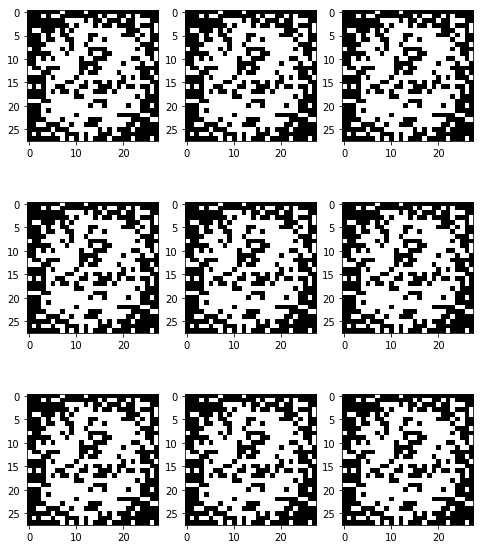
























 63%|██████▎   | 63/100 [13:20<08:05, 13.13s/it]






















 64%|██████▍   | 64/100 [13:32<07:49, 13.04s/it]

D Loss:  0.6552790403366089
G Loss:  2.07757306098938
D Loss:  0.6527888774871826
G Loss:  2.039065361022949


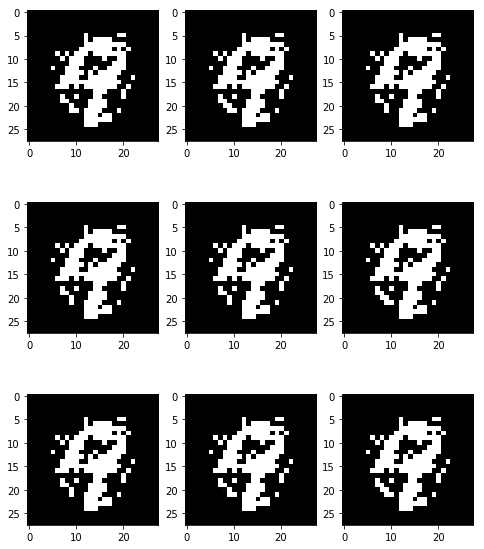
























 65%|██████▌   | 65/100 [13:46<07:41, 13.18s/it]






















 66%|██████▌   | 66/100 [13:59<07:23, 13.04s/it]

D Loss:  0.6343154907226562
G Loss:  2.106991767883301
D Loss:  0.6292868256568909
G Loss:  2.0903501510620117


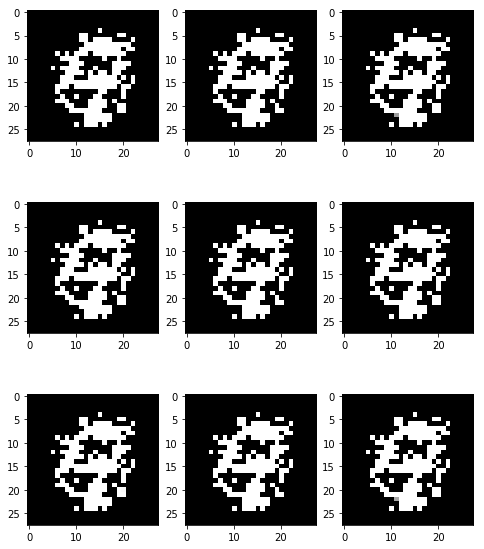
























 67%|██████▋   | 67/100 [14:12<07:14, 13.18s/it]






















 68%|██████▊   | 68/100 [14:25<06:56, 13.02s/it]

D Loss:  0.6550602912902832
G Loss:  2.0668559074401855
D Loss:  0.6639814376831055
G Loss:  1.9935213327407837


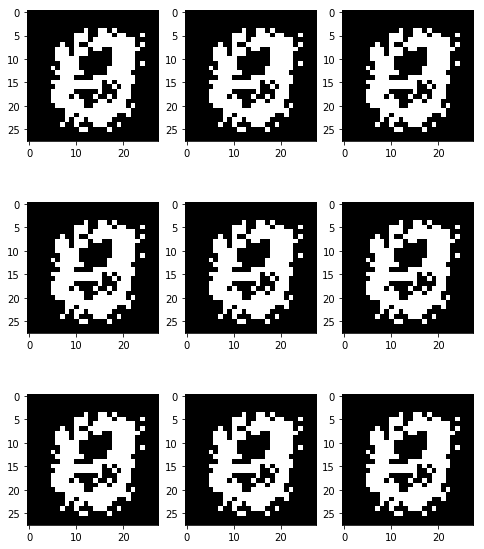
























 69%|██████▉   | 69/100 [14:38<06:48, 13.16s/it]






















 70%|███████   | 70/100 [14:51<06:30, 13.03s/it]

D Loss:  0.6382099390029907
G Loss:  2.124650001525879
D Loss:  0.6610496044158936
G Loss:  2.0374293327331543


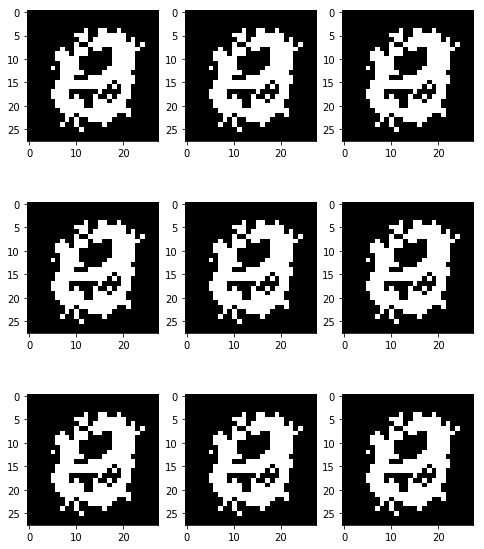
























 71%|███████   | 71/100 [15:04<06:21, 13.14s/it]






















 72%|███████▏  | 72/100 [15:17<06:00, 12.87s/it]

D Loss:  0.6670538187026978
G Loss:  2.114509344100952
D Loss:  0.6566324830055237
G Loss:  2.158316135406494


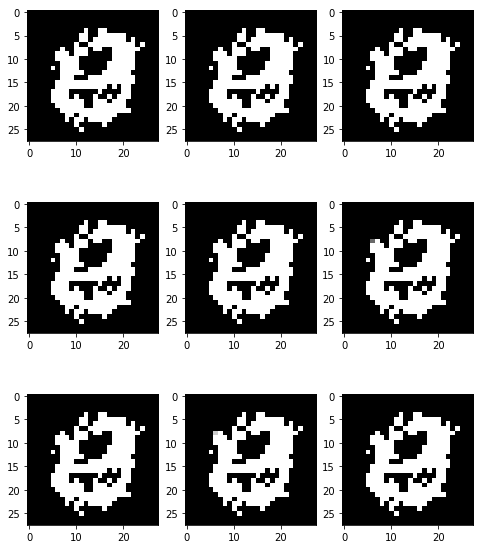
























 73%|███████▎  | 73/100 [15:30<05:52, 13.04s/it]






















 74%|███████▍  | 74/100 [15:43<05:36, 12.94s/it]

D Loss:  0.6459994316101074
G Loss:  2.2024829387664795
D Loss:  0.6784201860427856
G Loss:  2.0430550575256348


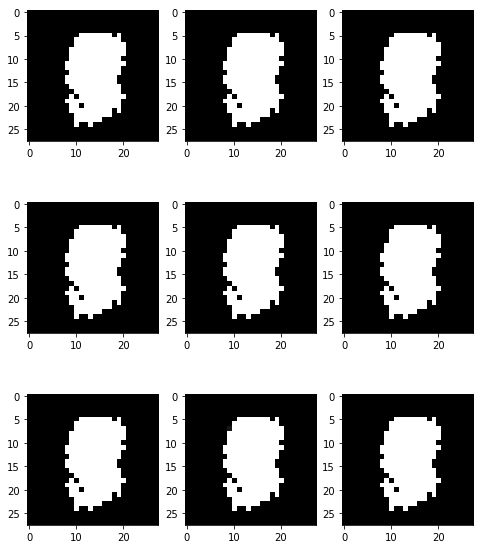
























 75%|███████▌  | 75/100 [15:56<05:27, 13.09s/it]






















 76%|███████▌  | 76/100 [16:09<05:11, 12.97s/it]

D Loss:  0.6508733034133911
G Loss:  2.088205575942993
D Loss:  0.6322548389434814
G Loss:  2.185274600982666


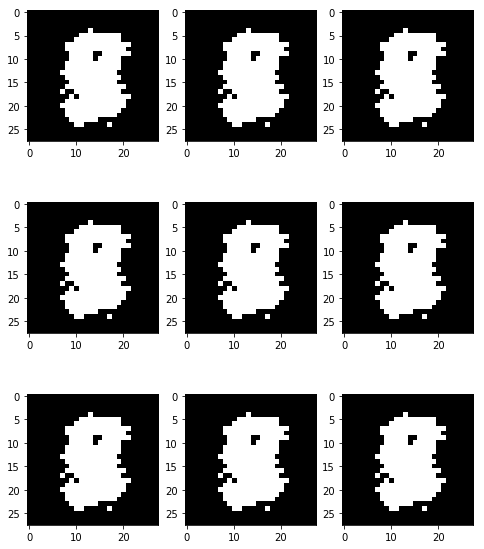
























 77%|███████▋  | 77/100 [16:22<05:01, 13.11s/it]






















 78%|███████▊  | 78/100 [16:35<04:45, 12.98s/it]

D Loss:  0.6490674018859863
G Loss:  2.119992733001709
D Loss:  0.6380965709686279
G Loss:  2.1465108394622803


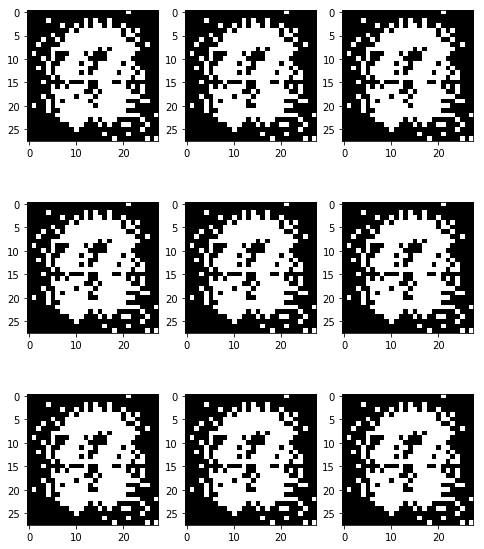
























 79%|███████▉  | 79/100 [16:49<04:36, 13.15s/it]






















 80%|████████  | 80/100 [17:01<04:20, 13.02s/it]

D Loss:  0.642175555229187
G Loss:  2.1349120140075684
D Loss:  0.675004243850708
G Loss:  2.030432939529419


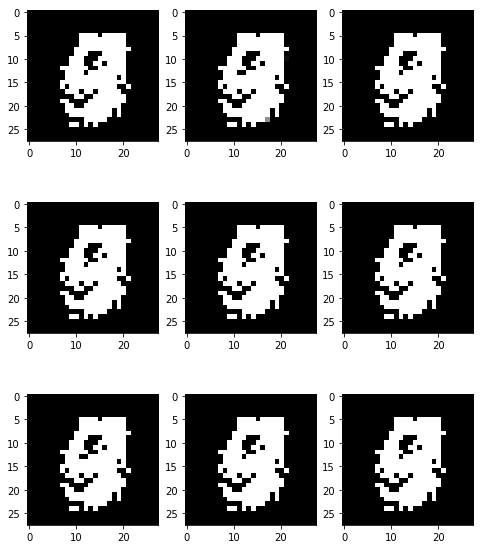
























 81%|████████  | 81/100 [17:14<04:06, 12.98s/it]






















 82%|████████▏ | 82/100 [17:26<03:46, 12.57s/it]

D Loss:  0.6723253130912781
G Loss:  2.087062358856201
D Loss:  0.6493644714355469
G Loss:  2.146820068359375


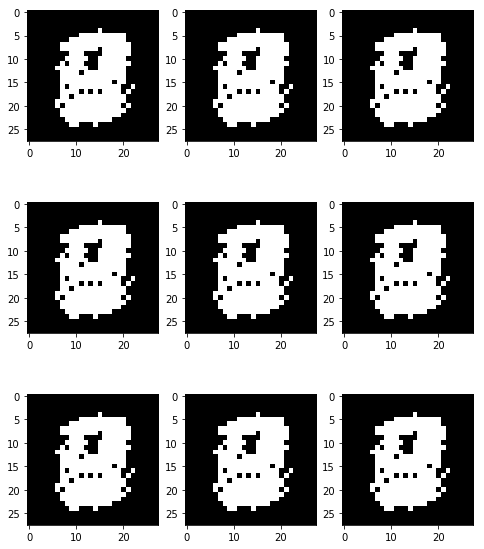
























 83%|████████▎ | 83/100 [17:38<03:32, 12.51s/it]






















 84%|████████▍ | 84/100 [17:50<03:15, 12.24s/it]

D Loss:  0.6755975484848022
G Loss:  1.9910614490509033
D Loss:  0.6715450882911682
G Loss:  2.11629581451416


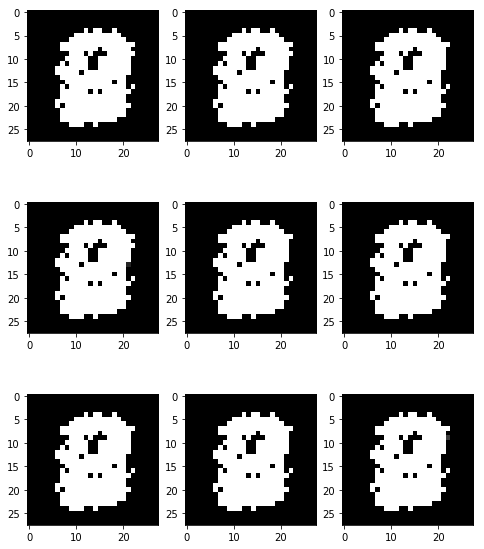
























 85%|████████▌ | 85/100 [18:03<03:07, 12.49s/it]






















 86%|████████▌ | 86/100 [18:15<02:52, 12.32s/it]

D Loss:  0.637343168258667
G Loss:  2.1046500205993652
D Loss:  0.6230223774909973
G Loss:  2.1109118461608887


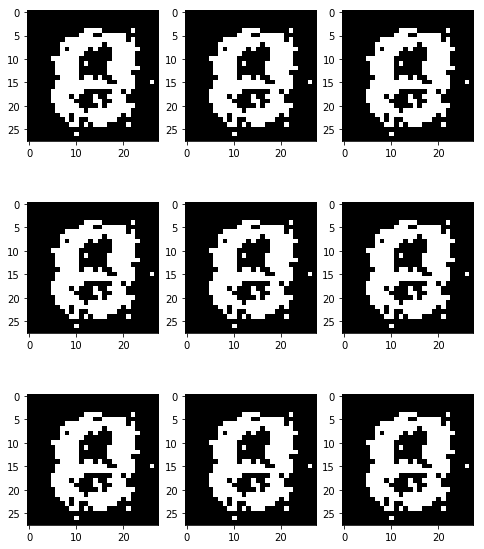
























 87%|████████▋ | 87/100 [18:27<02:40, 12.34s/it]






















 88%|████████▊ | 88/100 [18:39<02:25, 12.11s/it]

D Loss:  0.6296872496604919
G Loss:  1.996888279914856
D Loss:  0.6522223353385925
G Loss:  2.1471643447875977


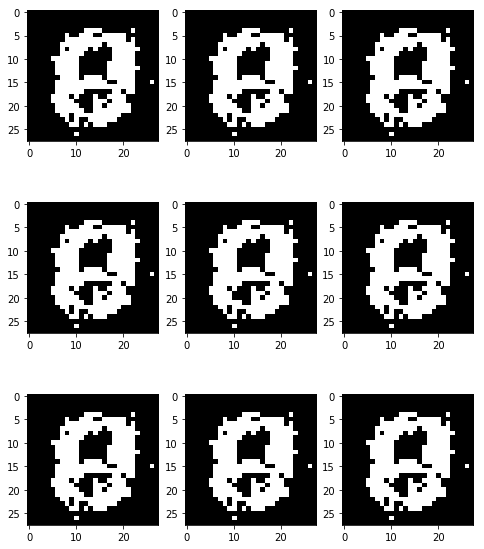
























 89%|████████▉ | 89/100 [18:52<02:17, 12.53s/it]






















 90%|█████████ | 90/100 [19:05<02:05, 12.59s/it]

D Loss:  0.6466097235679626
G Loss:  2.107593536376953
D Loss:  0.6550500988960266
G Loss:  2.133277416229248


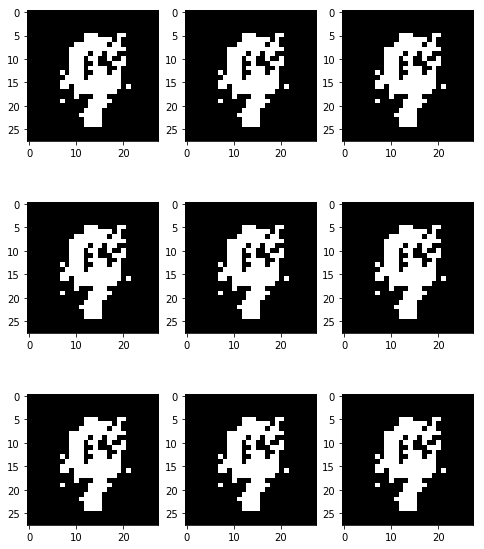
























 91%|█████████ | 91/100 [19:17<01:52, 12.51s/it]






















 92%|█████████▏| 92/100 [19:29<01:38, 12.30s/it]

D Loss:  0.6471163630485535
G Loss:  2.0799124240875244
D Loss:  0.6422531008720398
G Loss:  2.149155378341675


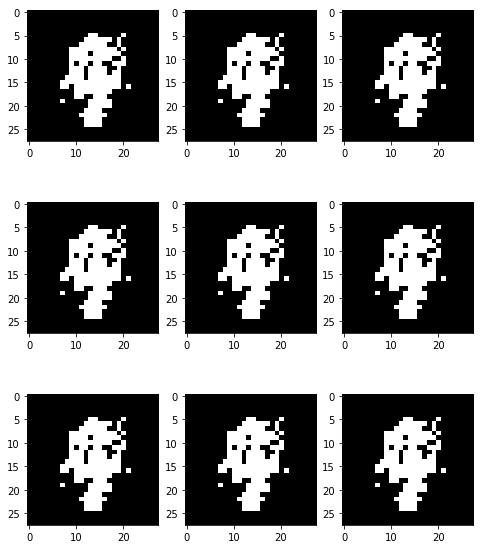
























 93%|█████████▎| 93/100 [19:42<01:26, 12.42s/it]






















 94%|█████████▍| 94/100 [19:55<01:15, 12.53s/it]

D Loss:  0.6571105718612671
G Loss:  2.0484070777893066
D Loss:  0.6640666723251343
G Loss:  2.114396333694458


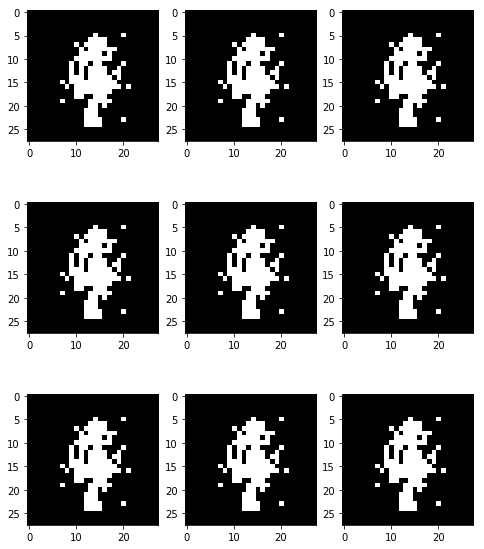
























 95%|█████████▌| 95/100 [20:08<01:04, 12.81s/it]






















 96%|█████████▌| 96/100 [20:21<00:51, 12.78s/it]

D Loss:  0.6433033347129822
G Loss:  2.188063621520996
D Loss:  0.6391083002090454
G Loss:  2.0534372329711914


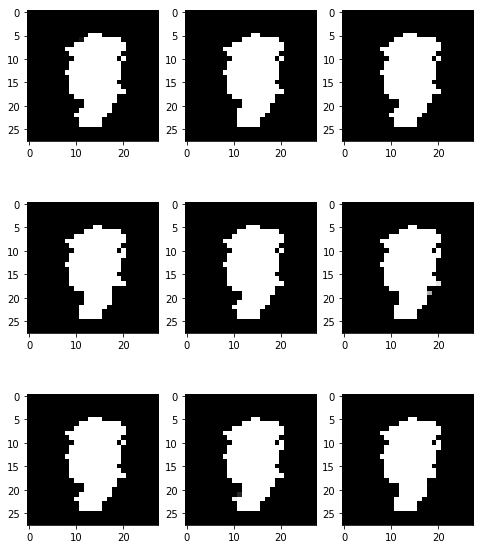
























 97%|█████████▋| 97/100 [20:34<00:38, 13.00s/it]






















 98%|█████████▊| 98/100 [20:47<00:25, 12.94s/it]

D Loss:  0.6475526094436646
G Loss:  1.9689929485321045
D Loss:  0.6650421619415283
G Loss:  2.0828497409820557


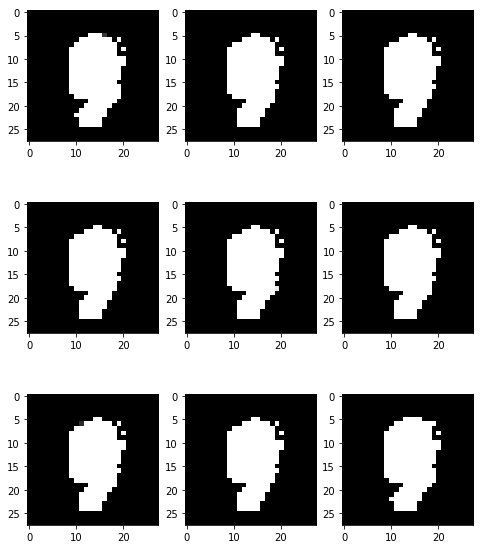
























 99%|█████████▉| 99/100 [21:00<00:12, 12.86s/it]






















100%|██████████| 100/100 [21:12<00:00, 12.70s/it]






















                                                 

D Loss:  0.6748511791229248
G Loss:  2.006753444671631


In [289]:
## Training loop

from tqdm import tqdm, trange

for epoch in trange(epochs, leave=False):
    for i, (images, _) in enumerate(train_loader):
        
#         targets_real = torch.ones((images.size(0), 1), requires_grad=False).to(device)
#         targets_fake = torch.zeros((images.size(0), 1), requires_grad=False).to(device)
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0)).to(device)
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2)).to(device)
        
#         images = images + (torch.randn_like(images)*0.1)
        images = images.to(device)
        
        optimizer_D.zero_grad()
        real_logits = discriminator(preprocess_img(images))
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        fake_logits = discriminator(fake_images)
        
        discriminator_loss = DLoss(real_logits, fake_logits, targets_real, targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()
        
#         for i in range(5):
        optimizer_G.zero_grad()

        fake_images = generator(noise(train_bs, noise_dim))
        fake_logits = discriminator(fake_images)

        generator_loss = GLoss(fake_logits, targets_real)
        generator_loss.backward()
        optimizer_G.step()
    
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        fig = plt.figure(figsize=(8,10))
        for i in np.arange(1, 10):
            ax = fig.add_subplot(3, 3, i)
            img = viz_batch[i].squeeze()
            plt.imshow(img)
        plt.show()